# V&V anemia screening and iron interventions

This notebook focuses on anemia screening, oral iron, and IV iron.

All the separate checks in this notebok are labeled with "CHECK" (all caps).

## Setup

In [1]:
from vivarium import Artifact, InteractiveContext
import pandas as pd, numpy as np, os

In [2]:
! pip list | grep vivarium

# [software verion + hash . date]

vivarium                  3.6.6
vivarium_build_utils      2.1.2
vivarium_cluster_tools    2.2.2
vivarium_dependencies     1.0.4
vivarium_gates_mncnh      25.1.dev10+g18b5f521f.d20260120 /mnt/share/homes/zmbc/src/vivarium_gates_mncnh
vivarium_public_health    4.13.19
vivarium_testing_utils    0.3.1


In [3]:
! pip freeze | grep vivarium

vivarium==3.6.6
vivarium_build_utils==2.1.2
vivarium_cluster_tools==2.2.2
vivarium_dependencies==1.0.4
-e git+https://github.com/ihmeuw/vivarium_gates_mncnh.git@ae36cf2c583c8e9373820a13b055083d95c0428c#egg=vivarium_gates_mncnh
vivarium_public_health==4.13.19
vivarium_testing_utils==0.3.1


In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from vivarium import InteractiveContext, Artifact

In [5]:
import vivarium_gates_mncnh
from vivarium.framework.configuration import build_model_specification
from pathlib import Path

path = Path(vivarium_gates_mncnh.__file__).parent / 'model_specifications/model_spec.yaml'
custom_model_specification = build_model_specification(path)
del custom_model_specification.configuration.observers
custom_model_specification.configuration.input_data.input_draw_number = 60
custom_model_specification.configuration.population.population_size = 20_000 * 10

artifact_path = custom_model_specification.configuration.input_data.artifact_path
art = Artifact(artifact_path)

artifact_path

'/mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model28.0/ethiopia.hdf'

In [6]:
draw_num = custom_model_specification.configuration.input_data.input_draw_number
draw = 'draw_' + str(draw_num)
draw

'draw_60'

CHECK: IFA coverage in the artifact does not vary by sex, age, or year.

Suite: artifact tests.

Type: precise assert.

In [7]:
ifa_coverage_at_anc = art.load('risk_factor.iron_folic_acid_supplementation.coverage')[draw]
assert (ifa_coverage_at_anc.groupby('parameter').nunique() == 1).all()
ifa_coverage_at_anc = ifa_coverage_at_anc.groupby('parameter').first()
# ok, so following the update,
    # cat1: uncovered
    # cat2: covered
ifa_coverage_at_anc = ifa_coverage_at_anc.loc['cat2']
ifa_coverage_at_anc

0.6131486122585059

CHECK: ANC1 coverage in the artifact does not vary by sex, age, or year.

Suite: artifact tests.

Type: precise assert.

In [8]:
anc1 = art.load('covariate.antenatal_care_1_visit_coverage_proportion.estimate')[draw]
assert len(anc1) == 1
anc1 = anc1.values[0]
ifa_coverage = ifa_coverage_at_anc * anc1
ifa_coverage

0.4614656393260721

In [9]:
ifa_effect = art.load('risk_factor.iron_folic_acid_supplementation.effect_size')[draw]
ifa_effect_hgb = ifa_effect['hemoglobin.exposure']
ifa_effect_hgb

9.922280818201326

CHECK: IV iron's effect on hemoglobin in the artifact does not vary by sex, age, or year.

Suite: artifact tests.

Type: precise assert.

In [10]:
iv_iron_effect_hgb = art.load('intervention.iv_iron.hemoglobin_effect_size')[draw]
assert len(iv_iron_effect_hgb) == 1
iv_iron_effect_hgb = iv_iron_effect_hgb.iloc[0]
iv_iron_effect_hgb

21.65971411676581

CHECK: Relative risks of hemoglobin in the artifact do not vary by sex, age, or year.

Suite: artifact tests.

Type: precise assert.

In [11]:
art_rrs = art.load('risk_factor.hemoglobin.relative_risk').reset_index()
exposure_levels = art_rrs.parameter.unique()
tmrel = exposure_levels[len([x for x in exposure_levels if x < 120])]
art_tmrel = art_rrs.loc[art_rrs.parameter == tmrel].drop(columns='parameter')
art_rrs = (art_rrs.set_index([x for x in art_rrs.columns if 'draw' not in x])
          / art_tmrel.set_index([x for x in art_tmrel.columns if 'draw' not in x])).reset_index()
assert (art_rrs.groupby(['affected_entity', 'parameter'])[draw].nunique() == 1).all()
art_rrs = art_rrs.groupby(['affected_entity', 'parameter'])[draw].first()
art_rrs

affected_entity                                parameter
depressive_disorders                           40.00000     1.840061
                                               40.11011     1.839232
                                               40.22022     1.838404
                                               40.33033     1.837576
                                               40.44044     1.836748
                                                              ...   
maternal_sepsis_and_other_maternal_infections  149.55956    0.946802
                                               149.66967    0.946836
                                               149.77978    0.946871
                                               149.88989    0.946905
                                               150.00000    0.946940
Name: draw_60, Length: 4000, dtype: float64

In [12]:
art_rrs.index.get_level_values('affected_entity').unique()

Index(['depressive_disorders', 'maternal_hemorrhage',
       'maternal_hypertensive_disorders',
       'maternal_sepsis_and_other_maternal_infections'],
      dtype='object', name='affected_entity')

CHECK: Probability of low ferritin in the artifact in the 'not_anemic' category is always half of the corresponding value in the 'mild' category.

Suite: artifact tests.

Type: precise assert.

In [13]:
art_low_ferritin_probs = art.load('ferritin.probability_of_low_ferritin')[draw]
# https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/mncnh_pregnancy/anemia_screening.html#id6
assert np.allclose(
    art_low_ferritin_probs.loc[(slice(None), slice(None), 'not_anemic')],
    art_low_ferritin_probs.loc[(slice(None), slice(None), 'mild')] / 2,
)
art_low_ferritin_probs

# I might have expected that more people would have low ferritin in the more extreme anemias, but it is actually the opposite

age_start  age_end  anemia_status_during_pregnancy
10.0       15.0     mild                              0.913531
                    moderate                          0.838612
                    not_anemic                        0.456765
                    severe                            0.759654
15.0       20.0     mild                              0.852187
                    moderate                          0.778244
                    not_anemic                        0.426094
                    severe                            0.735942
20.0       25.0     mild                              0.857813
                    moderate                          0.785119
                    not_anemic                        0.428906
                    severe                            0.736791
25.0       30.0     mild                              0.856926
                    moderate                          0.780867
                    not_anemic                        0.428463
    

Whole bunch of checks contained in this function. Precise asserts, in the interactive sim test suite, unless noted otherwise.

Before first step:

* CHECK: ANC attendance column starts as all null.
* CHECK: Hemoglobin and ferritin screening coverage columns start as all null, *and stay that way until the screening timestep*.
* CHECK: Oral iron column starts as all 'no_treatment'.
* CHECK: Each simulant's hemoglobin value should be lower than their 'raw_hemoglobin' value (the simulant's draw from the GBD distribution) by baseline IFA coverage times the IFA effect on hemoglobin.

After first-trimester ANC timestep:

* CHECK: ANC attendance column all non-null.
* CHECK: Oral iron column remains 'no_treatment' for simulants who did not attend first-trimester ANC.
* CHECK: Oral iron column all 'mms' for simulants who did attend first-trimester ANC, in an MMS scale-up scenario.
* CHECK: Oral iron column a mix of 'ifa' and 'no_treatment' in non-MMS scale-up scenarios.
* CHECK: In non-MMS scale-up scenarios, proportion of those attending first-trimester ANC who received IFA should match IFA coverage from artifact. Type: fuzzy check of proportion.
* CHECK: Simulants who received IFA or MMS on this timestep should have had their hemoglobin value increased by the IFA effect (shared by MMS), relative to the previous timestep.
* CHECK: Simulants who did not receive oral iron on this timestep should have the same hemoglobin they had on the previous timestep.

After later-pregnancy screening timestep:

* CHECK: In non-screening-scale-up scenarios, there is non-zero hemoglobin screening.
* CHECK: In screening scale-up scenarios, the simulants with hemoglobin screening coverage are exactly those who attend later-pregnancy ANC.
* CHECK: The proportion of simulants with truly low hemoglobin (hemoglobin <100) who test low (out of those who test) is approximately the documented 85% sensitivity. Type: fuzzy check of proportion.
* CHECK: The proportion of simulants with truly adequate hemoglobin (hemoglobin >= 100) who test adequate (out of those who test) is approximately the documented 80% specificity. Type: fuzzy check of proportion. 
* CHECK: In non-screening-scale-up scenarios, there is zero ferritin screening.
* CHECK: In screening scale-up scenarios, the simulants with ferritin screening coverage are exactly those who test low hemoglobin.
* CHECK: The proportion of simulants who test low ferritin (out of those who are tested) matches the target in the artifact (by age and anemia status). Type: fuzzy check of proportion.

After later-pregnancy intervention timestep:

* CHECK: In non-MMS-scaleup scenarios, the only change to oral iron coverage vs the previous timestep is some later-pregnancy-only-ANC-attending simulants shifting from 'none' to 'ifa'.
* CHECK: In MMS-scaleup scenarios, the only change to oral iron coverage vs the previous timestep is some later-pregnancy-only-ANC-attending simulants shifting from 'none' to 'mms'.
* CHECK: No IV iron received in non-IV-iron scaleup scenarios.
* CHECK: In IV-iron scaleup scenarios, IV iron received by exactly the simulants who test low ferritin.
* CHECK: Hemoglobin unchanged from previous timestep for simulants who neither changed oral iron coverage on this timestep, nor received IV iron.
* CHECK: Hemoglobin increased vs previous timestep in those who received IV iron by the IV iron effect size on hemoglobin.
* CHECK: Hemoglobin increased vs previous timestep in those who received new oral iron and did NOT receive IV iron by the IFA effect size on hemoglobin.

For each outcome (maternal hemorrhage and maternal sepsis) timestep:

* CHECK: Hemoglobin unchanged from after later-pregnancy intervention timestep.
* CHECK: Simulant-level relative risk on this outcome equals a recalculated interpolation of the artifact RRs.
* CHECK: The relative risk of the event happening in each quantile-bin of hemoglobin (vs the quantile-bin that contains the TMREL) approximately matches the mean of the artifact RRs for hemoglobin values in that quantile-bin. Type: manual, since this is a pretty odd check with lots of room for imprecision. We should consider if there is another good way for us to (partially) check this.

In [14]:
def check_hemoglobin_in_interactive_sim(scenario):
    from copy import deepcopy
    custom_model_specification_scenario = deepcopy(custom_model_specification)
    custom_model_specification_scenario.configuration.intervention.scenario = scenario

    sim = InteractiveContext(custom_model_specification_scenario)

    hemoglobin_component = sim.list_components()['risk_factor.hemoglobin']
    sim_step_name = hemoglobin_component._sim_step_name
    sim_step_name()

    initial_pop = sim.get_population()
    assert initial_pop.anc_attendance.isnull().all()
    assert (initial_pop.oral_iron_intervention == 'no_treatment').all()

    # https://github.com/ihmeuw/vivarium_public_health/blob/3b2b4f13ef53c0e9fd378e824eeb81a9057fea8d/src/vivarium_public_health/risks/base_risk.py#L303-L305
    raw_hemoglobin = hemoglobin_component.exposure_distribution.ppf(hemoglobin_component.propensity(initial_pop.index)).rename('raw_hemoglobin')
    initial_hemoglobin = sim.get_value('hemoglobin.exposure')(initial_pop.index).rename('initial_hemoglobin')

    assert sim_step_name() == "first_trimester_anc"
    sim.step()
    first_trimester_anc_pop = sim.get_population()
    assert first_trimester_anc_pop.anc_attendance.notnull().all()
    assert (first_trimester_anc_pop[
        first_trimester_anc_pop.anc_attendance.isin(['none', 'later_pregnancy_only'])
    ].oral_iron_intervention == 'no_treatment').all(), "people receiving IFA before screening who did not attend ANC in first trimester"

    if scenario in ('baseline', 'anemia_screening_vv', 'anemia_screening_and_iv_iron_scaleup'):
        # are we seeing the right coverage of IFA among those who attend ANC in the first trimester?
        print(f'Target IFA coverage at ANC: {ifa_coverage_at_anc}')
    elif scenario == 'mms_full_scaleup':
        assert (
            first_trimester_anc_pop.loc[~first_trimester_anc_pop.anc_attendance.isin(['none', 'later_pregnancy_only']), 'oral_iron_intervention'] == 'mms'
        ).all(), "MMS not fully scaled up!"
    print('Simulated oral iron coverage at ANC in first trimester:')
    display(first_trimester_anc_pop.loc[~first_trimester_anc_pop.anc_attendance.isin(['none', 'later_pregnancy_only'])].oral_iron_intervention.value_counts(normalize=True))

    first_trimester_anc_pop = pd.concat([
        # NOTE: In previous versions of this notebook we also checked the hemoglobin_exposure column in the state table
        # This is an implementation detail that won't be needed after the population refactor, and it lags behind the
        # actual value by one timestep, which is a bit confusing.
        # We ignore it here and check everything using the pipeline.
        first_trimester_anc_pop.drop(columns=['hemoglobin_exposure']),
        raw_hemoglobin,
        initial_hemoglobin,
        sim.get_value('hemoglobin.exposure')(first_trimester_anc_pop.index).rename('hemoglobin_exposure'),
        sim.get_value('hemoglobin_on_maternal_hemorrhage.relative_risk')(first_trimester_anc_pop.index)
    ], axis=1)

    print('Mean hemoglobin exposure: GBD vs after first trimester ANC in sim')
    display(first_trimester_anc_pop[['raw_hemoglobin', 'hemoglobin_exposure']].mean())

    if scenario in ('baseline', 'anemia_screening_vv', 'anemia_screening_and_iv_iron_scaleup'):
        # hemoglobin exposure is still lower at this point than GBD estimates, because not all IFA has been applied
        assert first_trimester_anc_pop['hemoglobin_exposure'].mean() < first_trimester_anc_pop['raw_hemoglobin'].mean()
    elif scenario == 'mms_full_scaleup':
        # There's not a clear target for whether this should be lower or higher,
        # since not all oral iron has been applied yet, but MMS has been scaled up to 100% of early ANC visits
        pass

    assert np.allclose(
        first_trimester_anc_pop.loc[first_trimester_anc_pop.oral_iron_intervention != 'no_treatment', 'hemoglobin_exposure'] -
        first_trimester_anc_pop.loc[first_trimester_anc_pop.oral_iron_intervention != 'no_treatment', 'initial_hemoglobin'],
        ifa_effect_hgb,
        rtol=0,
        atol=1e-13,
    ), "Oral iron effect does not match expectation from recalculation"

    assert (
        first_trimester_anc_pop.loc[first_trimester_anc_pop.oral_iron_intervention == 'no_treatment', 'hemoglobin_exposure'] ==
        first_trimester_anc_pop.loc[first_trimester_anc_pop.oral_iron_intervention == 'no_treatment', 'initial_hemoglobin']
    ).all(), "hemoglobin modified in simulants not receiving oral iron"

    assert np.allclose(
        first_trimester_anc_pop['raw_hemoglobin'] - first_trimester_anc_pop['initial_hemoglobin'],
        ifa_coverage * ifa_effect_hgb,
        rtol=0,
        atol=1e-13,
    ), "IFA deletion does not match expectation from recalculation"

    assert sim_step_name() == "later_pregnancy_screening"
    assert (~first_trimester_anc_pop.filter(like='screening_coverage')).all().all(), "Screening occurred before screening timestep"
    assert first_trimester_anc_pop.anemia_status_during_pregnancy.isnull().all(), "Anemia status during pregnancy assigned before screening timestep"

    sim.step() # Step past screening
    pop_after_screening = sim.get_population()
    pop_after_screening = pd.concat([
        pop_after_screening.drop(columns=['hemoglobin_exposure']),
        sim.get_value('hemoglobin.exposure')(pop_after_screening.index).rename('hemoglobin_exposure'),
    ], axis=1)

    assert pop_after_screening["hemoglobin_screening_coverage"].any(), "No baseline hemoglobin screening"
    if scenario in ('baseline', 'mms_total_scaleup'):
        assert not pop_after_screening["ferritin_screening_coverage"].any(), "Ferritin screening when not scaled up"
    elif scenario in ('anemia_screening_vv', 'anemia_screening_and_iv_iron_scaleup'):
        assert pop_after_screening[~pop_after_screening.anc_attendance.isin(['none', 'first_trimester_only'])].hemoglobin_screening_coverage.all()
        # NOTE: ferritin_screening_coverage column is not correct!
        assert (
            (pop_after_screening.tested_hemoglobin == 'low')
            ==
            (pop_after_screening.tested_ferritin != 'not_tested')
        ).all(), "Ferritin screening not fully scaled up, or applied to those not testing low hemoglobin!"
        # NOTE: anemia_status_during_pregnancy column is not updated!
        # https://github.com/ihmeuw/vivarium_gates_mncnh/blob/98980208ebcf8c4f19fa121f6ca20eba56357840/src/vivarium_gates_mncnh/components/screening.py#L90
        anemia_status_during_pregnancy = (
            pd.cut(
                pop_after_screening['hemoglobin_exposure'],
                bins=[-np.inf, 70, 100, 110],
                labels=["severe", "moderate", "mild"],
                right=False,
            )
            .astype("object")
            .fillna("not_anemic")
        )
        age_cutoffs = sorted(list(set(art_low_ferritin_probs.index.get_level_values('age_start')) | set(art_low_ferritin_probs.index.get_level_values('age_end'))))
        age_groups = (
            pd.cut(
                pop_after_screening['age'],
                bins=age_cutoffs,
                right=False,
            )
        )
        sim_ferritin_results = (
            pop_after_screening.assign(
                anemia_status_during_pregnancy=anemia_status_during_pregnancy,
                age_start=age_groups.cat.categories.left[age_groups.cat.codes],
                age_end=age_groups.cat.categories.right[age_groups.cat.codes],
            )
                [pop_after_screening.tested_ferritin != 'not_tested']
                .groupby(['age_start', 'age_end', 'anemia_status_during_pregnancy'])
                .tested_ferritin.value_counts(normalize=True).loc[(slice(None), slice(None), slice(None), 'low')]
        )
        comparison = art_low_ferritin_probs.rename('target').to_frame().join(sim_ferritin_results.rename('sim'))
        print('Percent of those tested who have low ferritin:')
        display(comparison)
    else:
        raise ValueError()

    # TODO: Why is this not working?
    # assert pop_after_screening.anemia_status_during_pregnancy.notnull().all()

    # https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/mncnh_pregnancy/anemia_screening.html#hemoglobin-screening-accuracy-instructions
    print('Specificity target (percent of true negatives that test negative): 80%')
    print('Observed:')
    display(pop_after_screening[
        (pop_after_screening.hemoglobin_exposure > 100) &
        (pop_after_screening.hemoglobin_screening_coverage)
    ].tested_hemoglobin.value_counts(dropna=False, normalize=True))

    print('Sensitivity target (percent of true positives that test positive): 85%')
    print('Observed:')
    display(pop_after_screening[
        (pop_after_screening.hemoglobin_exposure < 100) &
        (pop_after_screening.hemoglobin_screening_coverage)
    ].tested_hemoglobin.value_counts(dropna=False, normalize=True))

    # COMMENTED OUT BECAUSE STATE TABLE HAS MISSING VALUE 
    #assert (sim.get_value('hemoglobin.exposure')(pop_after_screening.index) == pop_after_screening.hemoglobin_exposure).all(), "Hemoglobin pipeline does not match state table"
    
    screening_step_hemoglobin_exposure = sim.get_value('hemoglobin.exposure')(pop_after_screening.index)    
    assert sim_step_name() == 'later_pregnancy_intervention'
    sim.step()
    pop_after_later_pregnancy_intervention = sim.get_population()

    oral_iron_changed = pop_after_later_pregnancy_intervention.oral_iron_intervention != pop_after_screening.oral_iron_intervention
    later_oral_iron_changes = pd.DataFrame({
        'oral_iron_before': pop_after_screening[oral_iron_changed].oral_iron_intervention,
        'oral_iron_after': pop_after_later_pregnancy_intervention[oral_iron_changed].oral_iron_intervention,
    })
    assert (later_oral_iron_changes.oral_iron_before == 'no_treatment').all()
    if scenario in ('baseline', 'anemia_screening_vv', 'anemia_screening_and_iv_iron_scaleup'):
        assert (later_oral_iron_changes.oral_iron_after == 'ifa').all()
    elif scenario == 'mms_total_scaleup':
        assert (later_oral_iron_changes.oral_iron_after == 'mms').all()
    print('Oral iron changes at later ANC:')
    display(later_oral_iron_changes)

    assert (pop_after_screening[oral_iron_changed].anc_attendance == 'later_pregnancy_only').all()

    iv_iron_received = pop_after_later_pregnancy_intervention.iv_iron_intervention == 'covered'

    if scenario in ('baseline', 'anemia_screening_vv', 'mms_total_scaleup'):
        assert not iv_iron_received.any(), "baseline IV iron"
    elif scenario == 'anemia_screening_and_iv_iron_scaleup':
        assert (
            (pop_after_later_pregnancy_intervention.tested_ferritin == 'low') ==
            iv_iron_received
        ).all(), "IV iron not fully scaled up, or given to people who did not test low ferritin"

    assert pop_after_screening[iv_iron_received].anc_attendance.isin(['first_trimester_and_later_pregnancy', 'later_pregnancy_only']).all()

    hemoglobin_exposure_after = sim.get_value('hemoglobin.exposure')(pop_after_later_pregnancy_intervention.index)
    assert (
        screening_step_hemoglobin_exposure[~oral_iron_changed & ~iv_iron_received] ==
        hemoglobin_exposure_after[~oral_iron_changed & ~iv_iron_received]
    ).all(), "Hemoglobin exposure changed at later intervention timestep for those not receiving later intervention"

    assert np.allclose(
        hemoglobin_exposure_after[oral_iron_changed & ~iv_iron_received] -
        screening_step_hemoglobin_exposure[oral_iron_changed & ~iv_iron_received],
        ifa_effect_hgb,
        rtol=0,
        atol=1e-13,
    ), "IFA effect does not match expectation from recalculation"

    assert np.allclose(
        hemoglobin_exposure_after[~oral_iron_changed & iv_iron_received] -
        screening_step_hemoglobin_exposure[~oral_iron_changed & iv_iron_received],
        iv_iron_effect_hgb,
        rtol=0,
        atol=1e-13,
    ), "IV iron effect does not match expectation from recalculation"

    # https://vivarium-research.readthedocs.io/en/latest/models/concept_models/vivarium_mncnh_portfolio/hemoglobin_module/module_document.html#end-of-pregnancy-hemoglobin-module
    assert np.allclose(
        hemoglobin_exposure_after[oral_iron_changed & iv_iron_received] -
        screening_step_hemoglobin_exposure[oral_iron_changed & iv_iron_received],
        iv_iron_effect_hgb,
        rtol=0,
        atol=1e-13,
    ), "IV iron effect combining with IFA effect (it shouldn't)"

    outcomes = ['maternal_hemorrhage', 'maternal_sepsis_and_other_maternal_infections']
    for outcome in outcomes:
        while sim_step_name() != outcome:
            sim.step()
        # now one more step to advance past
        sim.step()

        stepped_pop = sim.get_population()
        assert (sim.get_value('hemoglobin.exposure')(stepped_pop.index) == hemoglobin_exposure_after).all(), "Changes to hemoglobin after late-pregnancy ANC"
        stepped_pop = pd.concat([
            stepped_pop.drop(columns=['hemoglobin_exposure']),
            raw_hemoglobin,
            initial_hemoglobin,
            sim.get_value('hemoglobin.exposure')(stepped_pop.index).rename('hemoglobin_exposure'),
            sim.get_value(f'hemoglobin_on_{outcome}.relative_risk')(stepped_pop.index)
        ], axis=1)

        outcome_art_rrs = art_rrs.loc[outcome]
        assert np.allclose(
            np.interp(stepped_pop['hemoglobin_exposure'], outcome_art_rrs.index, outcome_art_rrs),
            stepped_pop[f'hemoglobin_on_{outcome}.relative_risk'],
            rtol=0,
            atol=1e-2,
        ), f"{outcome} relative risk doesn't match recalculation"

        # NOTE: This plot is redundant to the check above
        import matplotlib.pyplot as plt
        plt.scatter(stepped_pop['raw_hemoglobin'], stepped_pop[f'hemoglobin_on_{outcome}.relative_risk'], s = 20, label='raw hemoglobin exposure')
        plt.scatter(stepped_pop['hemoglobin_exposure'], stepped_pop[f'hemoglobin_on_{outcome}.relative_risk'], s = 20, label='intervention-modified hemoglobin exposure')
        plt.plot(outcome_art_rrs.index, outcome_art_rrs, label='artifact RR curve', color='tab:green')
        plt.legend()
        plt.xlabel('hemoglobin exposure (g/L)')
        plt.ylabel(f'relative risk of {outcome}')
        plt.title('Which hemoglobin exposure measure is affecting RR?')
        plt.show()

        # ok so now let's check if this actually translates to incidence

        # Bin hemoglobin exposure
        stepped_pop['hb_bin'] = pd.qcut(stepped_pop['hemoglobin_exposure'], 30)

        # Calculate rate of outcome == True in each bin
        sim_rate = stepped_pop.groupby('hb_bin')[outcome].value_counts(normalize=True).unstack().fillna(0)

        # Find the bin containing 120 (tmrel)
        tmrel_bin = [b for b in sim_rate.index if b.left <= tmrel < b.right][0]
        tmrel_rate = sim_rate.loc[tmrel_bin]

        art_rrs_by_bin = art_rrs.reset_index().assign(hb_bin=lambda df: pd.cut(df.parameter, stepped_pop['hb_bin'].cat.categories)).groupby('hb_bin')[draw].mean()
        art_rrs_by_bin.plot(kind='line', color='tab:orange', label='Artifact')

        plt.xlabel('Hemoglobin Exposure (binned)')
        plt.ylabel('Relative Rate vs. Bin Containing 120 g/L')
        plt.title(f'Relative Rate of {outcome} by Hemoglobin Exposure')
        (sim_rate[True] / tmrel_rate[True]).plot(kind='bar')
        plt.legend()
        plt.xticks(rotation=90)
        plt.grid()
        plt.show()

    stepped_pop = sim.get_population()
    assert (sim.get_value('hemoglobin.exposure')(stepped_pop.index) == hemoglobin_exposure_after).all(), "Changes to hemoglobin after late-pregnancy ANC"
    stepped_pop = pd.concat([
        stepped_pop.drop(columns=['hemoglobin_exposure']),
        raw_hemoglobin,
        initial_hemoglobin,
        sim.get_value('hemoglobin.exposure')(stepped_pop.index).rename('hemoglobin_exposure'),
    ], axis=1)
    return stepped_pop

/mnt/share/homes/zmbc/mambaforge/envs/vivarium_gates_mncnh_simulation/lib/python3.11/site-packages/vivarium_public_health/plugins/parser.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


2026-01-23 15:28:49.949 | INFO     | simulation_1-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model28.0/ethiopia.hdf.


2026-01-23 15:28:49.950 | INFO     | simulation_1-artifact_manager:80 - Artifact base filter terms are ['draw == 60'].


2026-01-23 15:28:49.951 | INFO     | simulation_1-artifact_manager:81 - Artifact additional filter terms are None.


2026-01-23 15:29:11.890 | WARNING  | simulation_1-results_manager:446 - Specified excluded stratifications are already not included by default: ['stillbirth', 'partial_term']


2026-01-23 15:29:11.891 | WARNING  | simulation_1-results_manager:446 - Specified excluded stratifications are already not included by default: ['stillbirth', 'partial_term']


2026-01-23 15:29:12.047 | INFO     | simulation_1-results_context:129 - The following stratifications are registered but not used by any observers: 
['ferritin_screening_coverage', 'hemoglobin_screening_coverage', 'sex']


2026-01-23 15:29:33.661 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-01-01 00:00:00


Target IFA coverage at ANC: 0.6131486122585059
Simulated oral iron coverage at ANC in first trimester:


oral_iron_intervention
ifa             0.615212
no_treatment    0.384788
Name: proportion, dtype: float64

Mean hemoglobin exposure: GBD vs after first trimester ANC in sim


raw_hemoglobin         119.272824
hemoglobin_exposure    117.294314
dtype: float64

2026-01-23 15:29:58.418 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-01-02 00:00:00


Specificity target (percent of true negatives that test negative): 80%
Observed:


tested_hemoglobin
adequate    0.800226
low         0.199774
Name: proportion, dtype: float64

Sensitivity target (percent of true positives that test positive): 85%
Observed:


tested_hemoglobin
low         0.84728
adequate    0.15272
Name: proportion, dtype: float64

2026-01-23 15:30:22.169 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-01-03 00:00:00


Oral iron changes at later ANC:


,oral_iron_before,oral_iron_after
8,no_treatment,ifa
11,no_treatment,ifa
17,no_treatment,ifa
57,no_treatment,ifa
60,no_treatment,ifa
...,...,...
199963,no_treatment,ifa
199977,no_treatment,ifa
199991,no_treatment,ifa
199996,no_treatment,ifa


2026-01-23 15:30:38.347 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-01-04 00:00:00


2026-01-23 15:31:00.659 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-01-05 00:00:00


2026-01-23 15:31:08.794 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-01-06 00:00:00


2026-01-23 15:31:17.110 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-01-07 00:00:00


2026-01-23 15:31:24.931 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-01-08 00:00:00


2026-01-23 15:31:33.353 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-01-09 00:00:00


2026-01-23 15:31:41.141 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-01-10 00:00:00


2026-01-23 15:31:49.086 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-01-11 00:00:00


2026-01-23 15:31:56.929 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-01-12 00:00:00


2026-01-23 15:32:04.918 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-01-13 00:00:00


/mnt/share/homes/zmbc/mambaforge/envs/vivarium_gates_mncnh_simulation/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


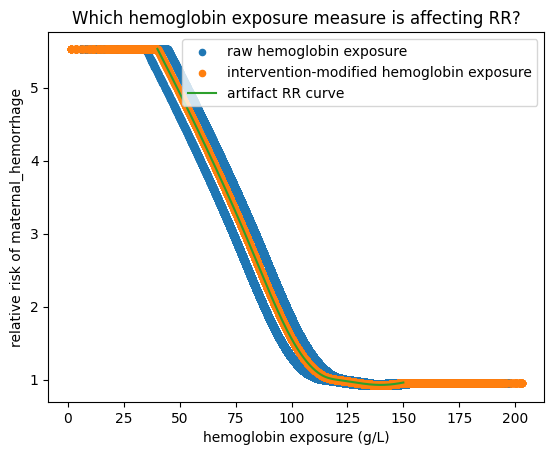

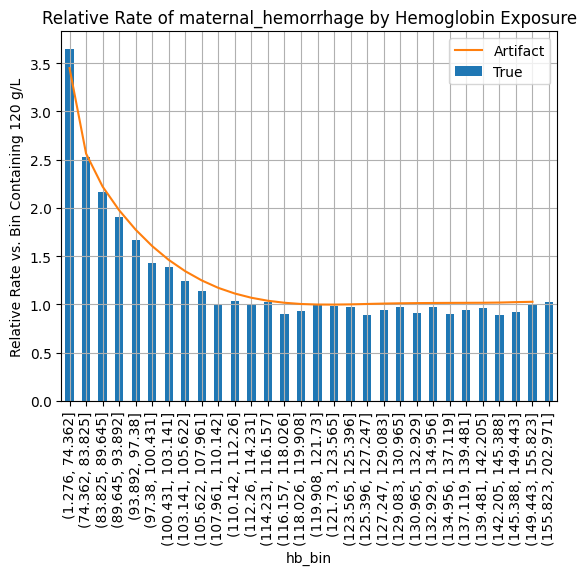

2026-01-23 15:32:35.613 | INFO     | simulation_1 - vivarium.framework.engine:284 - 2025-01-14 00:00:00


/mnt/share/homes/zmbc/mambaforge/envs/vivarium_gates_mncnh_simulation/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


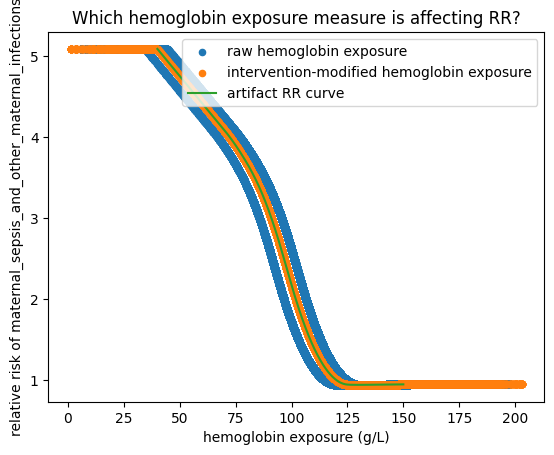

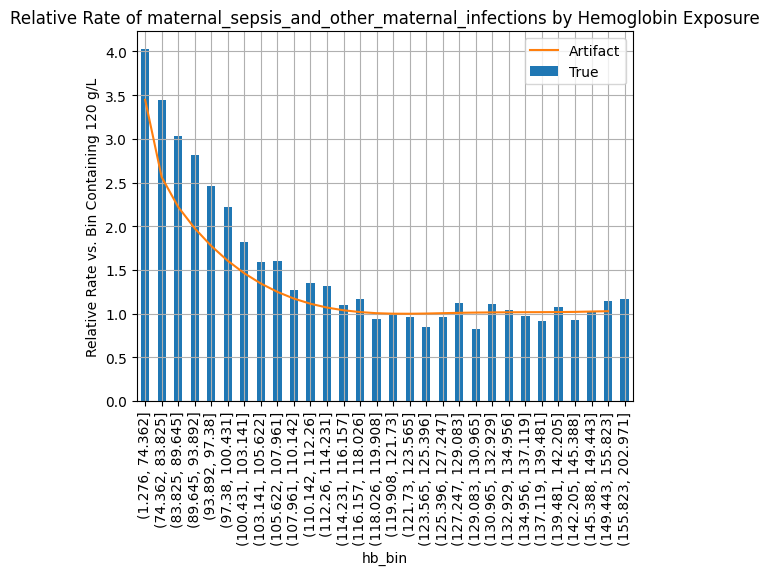

In [15]:
baseline_final_pop = check_hemoglobin_in_interactive_sim('baseline')

2026-01-23 15:33:16.000 | INFO     | simulation_2-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model28.0/ethiopia.hdf.


2026-01-23 15:33:16.001 | INFO     | simulation_2-artifact_manager:80 - Artifact base filter terms are ['draw == 60'].


2026-01-23 15:33:16.002 | INFO     | simulation_2-artifact_manager:81 - Artifact additional filter terms are None.


2026-01-23 15:33:39.119 | WARNING  | simulation_2-results_manager:446 - Specified excluded stratifications are already not included by default: ['stillbirth', 'partial_term']


2026-01-23 15:33:39.120 | WARNING  | simulation_2-results_manager:446 - Specified excluded stratifications are already not included by default: ['stillbirth', 'partial_term']


2026-01-23 15:33:39.260 | INFO     | simulation_2-results_context:129 - The following stratifications are registered but not used by any observers: 
['ferritin_screening_coverage', 'hemoglobin_screening_coverage', 'sex']


2026-01-23 15:34:00.000 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-01-01 00:00:00


Simulated oral iron coverage at ANC in first trimester:


oral_iron_intervention
mms    1.0
Name: proportion, dtype: float64

Mean hemoglobin exposure: GBD vs after first trimester ANC in sim


raw_hemoglobin         119.272824
hemoglobin_exposure    118.920675
dtype: float64

2026-01-23 15:34:21.613 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-01-02 00:00:00


Specificity target (percent of true negatives that test negative): 80%
Observed:


tested_hemoglobin
adequate    0.799625
low         0.200375
Name: proportion, dtype: float64

Sensitivity target (percent of true positives that test positive): 85%
Observed:


tested_hemoglobin
low         0.846645
adequate    0.153355
Name: proportion, dtype: float64

2026-01-23 15:34:43.673 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-01-03 00:00:00


Oral iron changes at later ANC:


,oral_iron_before,oral_iron_after
8,no_treatment,mms
11,no_treatment,mms
13,no_treatment,mms
17,no_treatment,mms
43,no_treatment,mms
...,...,...
199977,no_treatment,mms
199986,no_treatment,mms
199991,no_treatment,mms
199996,no_treatment,mms


2026-01-23 15:34:58.043 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-01-04 00:00:00


2026-01-23 15:35:19.530 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-01-05 00:00:00


2026-01-23 15:35:29.418 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-01-06 00:00:00


2026-01-23 15:35:37.730 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-01-07 00:00:00


2026-01-23 15:35:45.114 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-01-08 00:00:00


2026-01-23 15:35:53.252 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-01-09 00:00:00


2026-01-23 15:36:01.214 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-01-10 00:00:00


2026-01-23 15:36:08.923 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-01-11 00:00:00


2026-01-23 15:36:16.617 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-01-12 00:00:00


2026-01-23 15:36:24.472 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-01-13 00:00:00


/mnt/share/homes/zmbc/mambaforge/envs/vivarium_gates_mncnh_simulation/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


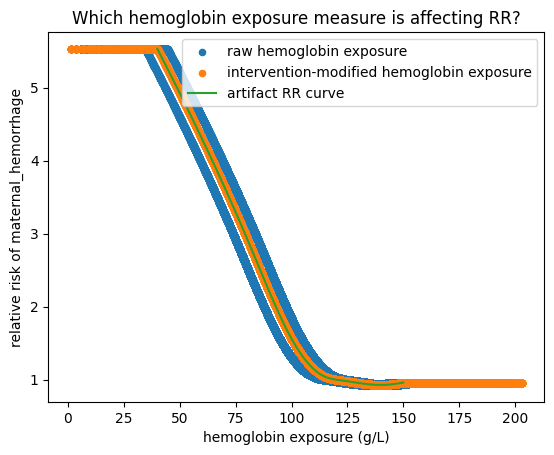

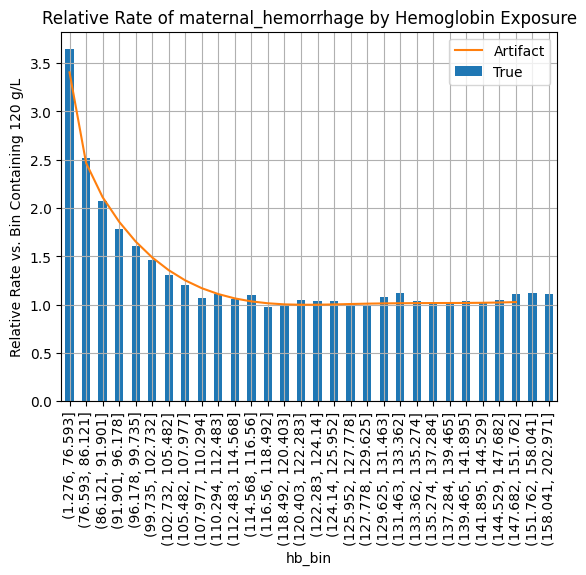

2026-01-23 15:36:54.710 | INFO     | simulation_2 - vivarium.framework.engine:284 - 2025-01-14 00:00:00


/mnt/share/homes/zmbc/mambaforge/envs/vivarium_gates_mncnh_simulation/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


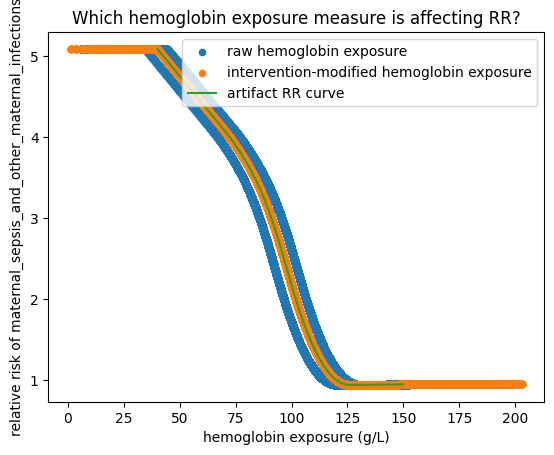

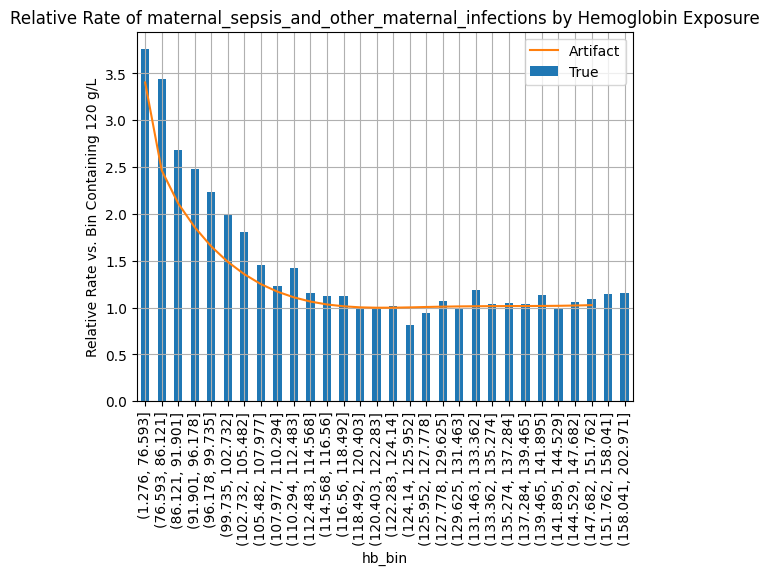

In [16]:
# so now let's checkout the mms universe
mms_final_pop = check_hemoglobin_in_interactive_sim('mms_total_scaleup')

In [17]:
# and screening
# NOTE: This scenario has been removed
# screening_final_pop = check_hemoglobin_in_interactive_sim('anemia_screening_vv')

# Generally looks reasonable, but ferritin proportions among those with moderate and severe anemia look pretty wiggly

2026-01-23 15:37:37.513 | INFO     | simulation_3-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model28.0/ethiopia.hdf.


2026-01-23 15:37:37.514 | INFO     | simulation_3-artifact_manager:80 - Artifact base filter terms are ['draw == 60'].


2026-01-23 15:37:37.515 | INFO     | simulation_3-artifact_manager:81 - Artifact additional filter terms are None.


2026-01-23 15:38:01.153 | WARNING  | simulation_3-results_manager:446 - Specified excluded stratifications are already not included by default: ['stillbirth', 'partial_term']


2026-01-23 15:38:01.154 | WARNING  | simulation_3-results_manager:446 - Specified excluded stratifications are already not included by default: ['stillbirth', 'partial_term']


2026-01-23 15:38:01.330 | INFO     | simulation_3-results_context:129 - The following stratifications are registered but not used by any observers: 
['ferritin_screening_coverage', 'hemoglobin_screening_coverage', 'sex']


2026-01-23 15:38:21.593 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-01-01 00:00:00


Target IFA coverage at ANC: 0.6131486122585059
Simulated oral iron coverage at ANC in first trimester:


oral_iron_intervention
ifa             0.615212
no_treatment    0.384788
Name: proportion, dtype: float64

Mean hemoglobin exposure: GBD vs after first trimester ANC in sim


raw_hemoglobin         119.272824
hemoglobin_exposure    117.294314
dtype: float64

2026-01-23 15:38:43.794 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-01-02 00:00:00


Percent of those tested who have low ferritin:


target       sim
age_start age_end anemia_status_during_pregnancy                    
10.0      15.0    mild                            0.913531  1.000000
                  moderate                        0.838612  0.880000
                  not_anemic                      0.456765  0.432432
                  severe                          0.759654  0.900000
15.0      20.0    mild                            0.852187  0.857143
                  moderate                        0.778244  0.794253
                  not_anemic                      0.426094  0.406284
                  severe                          0.735942  0.738806
20.0      25.0    mild                            0.857813  0.875598
                  moderate                        0.785119  0.790180
                  not_anemic                      0.428906  0.413825
                  severe                          0.736791  0.733929
25.0      30.0    mild                            0.856926  0.866779
                  moderate                        0.780867  0.796326
                  not_anemic                      0.428463  0.449485
                  severe                          0.726262  0.736735
30.0      35.0    mild                            0.858529  0.855292
                  moderate                        0.781551  0.791230
                  not_anemic                      0.429264  0.420330
                  severe                          0.716898  0.725888
35.0      40.0    mild                            0.859204  0.877358
                  moderate                        0.777320  0.780519
                  not_anemic                      0.429602  0.431994
                  severe                          0.706634  0.692308
40.0      45.0    mild                            0.846866  0.795455
                  moderate                        0.762404  0.751196
                  not_anemic                      0.423433  0.408348
                  severe                          0.704485  0.780822
45.0      50.0    mild                            0.849911  0.812500
                  moderate                        0.767547  0.778689
                  not_anemic                      0.424956  0.458333
                  severe                          0.707815  0.571429
50.0      55.0    mild                            0.867403  1.000000
                  moderate                        0.802023  0.500000
                  not_anemic                      0.433702  0.500000
                  severe                          0.734981  1.000000

Specificity target (percent of true negatives that test negative): 80%
Observed:


tested_hemoglobin
adequate    0.801117
low         0.198883
Name: proportion, dtype: float64

Sensitivity target (percent of true positives that test positive): 85%
Observed:


tested_hemoglobin
low         0.848052
adequate    0.151948
Name: proportion, dtype: float64

2026-01-23 15:39:07.061 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-01-03 00:00:00


Oral iron changes at later ANC:


,oral_iron_before,oral_iron_after
8,no_treatment,ifa
11,no_treatment,ifa
17,no_treatment,ifa
57,no_treatment,ifa
60,no_treatment,ifa
...,...,...
199963,no_treatment,ifa
199977,no_treatment,ifa
199991,no_treatment,ifa
199996,no_treatment,ifa


2026-01-23 15:39:22.617 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-01-04 00:00:00


2026-01-23 15:39:44.209 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-01-05 00:00:00


2026-01-23 15:39:52.272 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-01-06 00:00:00


2026-01-23 15:40:19.602 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-01-07 00:00:00


2026-01-23 15:40:34.061 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-01-08 00:00:00


2026-01-23 15:40:42.136 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-01-09 00:00:00


2026-01-23 15:40:49.496 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-01-10 00:00:00


2026-01-23 15:40:56.757 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-01-11 00:00:00


2026-01-23 15:41:04.252 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-01-12 00:00:00


2026-01-23 15:41:11.736 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-01-13 00:00:00


/mnt/share/homes/zmbc/mambaforge/envs/vivarium_gates_mncnh_simulation/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


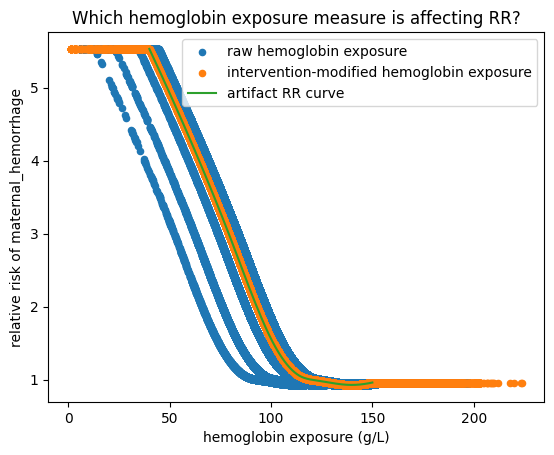

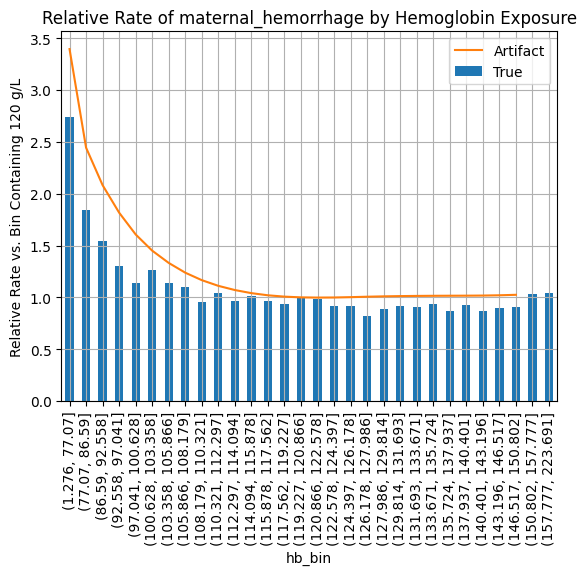

2026-01-23 15:41:42.769 | INFO     | simulation_3 - vivarium.framework.engine:284 - 2025-01-14 00:00:00


/mnt/share/homes/zmbc/mambaforge/envs/vivarium_gates_mncnh_simulation/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


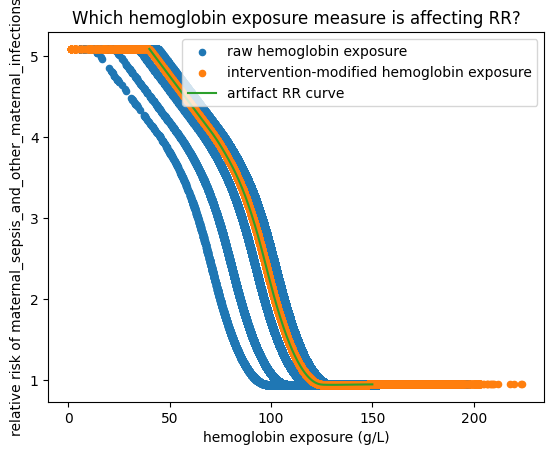

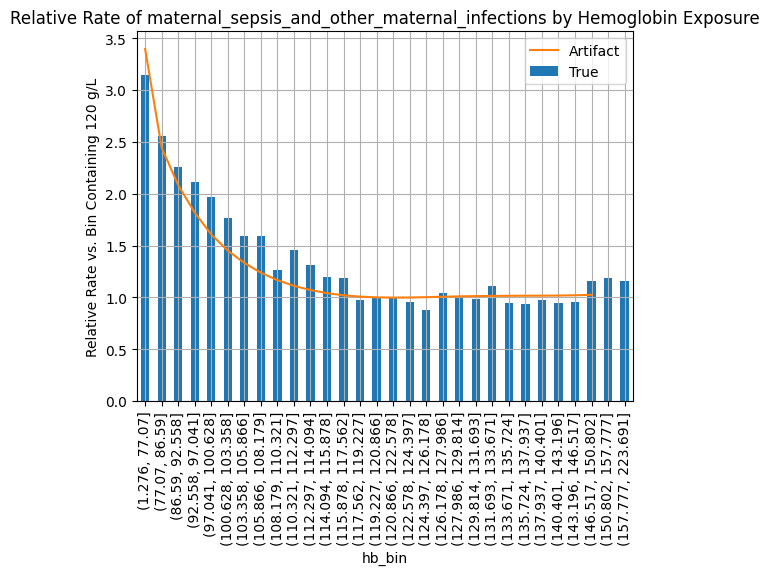

In [18]:
iv_iron_final_pop = check_hemoglobin_in_interactive_sim('anemia_screening_and_iv_iron_scaleup')

In [19]:
compare_population = mms_final_pop.join(baseline_final_pop, lsuffix='_mms_total_scaleup', rsuffix='_baseline')
compare_population

,tracked_mms_total_scaleup,age_mms_total_scaleup,entrance_time_mms_total_scaleup,exit_time_mms_total_scaleup,location_mms_total_scaleup,alive_mms_total_scaleup,sex_mms_total_scaleup,anc_attendance_mms_total_scaleup,ultrasound_type_mms_total_scaleup,stated_gestational_age_mms_total_scaleup,...,effect_of_low_birth_weight_and_short_gestation_on_late_neonatal_neonatal_sepsis_and_other_neonatal_infections_relative_risk_baseline,effect_of_low_birth_weight_and_short_gestation_on_early_neonatal_neonatal_preterm_birth_with_rds_relative_risk_baseline,effect_of_low_birth_weight_and_short_gestation_on_late_neonatal_neonatal_preterm_birth_with_rds_relative_risk_baseline,effect_of_low_birth_weight_and_short_gestation_on_early_neonatal_neonatal_preterm_birth_without_rds_relative_risk_baseline,effect_of_low_birth_weight_and_short_gestation_on_late_neonatal_neonatal_preterm_birth_without_rds_relative_risk_baseline,effect_of_low_birth_weight_and_short_gestation_on_late_neonatal_neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma_relative_risk_baseline,effect_of_low_birth_weight_and_short_gestation_on_early_neonatal_neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma_relative_risk_baseline,raw_hemoglobin_baseline,initial_hemoglobin_baseline,hemoglobin_exposure_baseline
0,True,32.951171,2024-12-31,NaT,Ethiopia,alive,Female,first_trimester_and_later_pregnancy,standard,38.604912,...,12.770088,15.230348,12.770088,15.230348,12.770088,12.770088,15.230348,110.800965,106.222173,116.144454
1,True,29.639247,2024-12-31,NaT,Ethiopia,alive,Female,first_trimester_only,no_ultrasound,38.622513,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,99.416114,94.837322,104.759603
2,True,31.824403,2024-12-31,NaT,Ethiopia,alive,Female,first_trimester_only,no_ultrasound,40.911945,...,1.726234,1.143949,1.726234,1.143949,1.726234,1.726234,1.143949,104.831516,100.252725,110.175006
3,True,31.479695,2024-12-31,NaT,Ethiopia,alive,Female,none,no_ultrasound,39.720257,...,1.768109,1.166106,1.768109,1.166106,1.768109,1.768109,1.166106,98.259774,93.680983,93.680983
4,True,21.380748,2024-12-31,NaT,Ethiopia,alive,Female,first_trimester_and_later_pregnancy,no_ultrasound,41.793543,...,1.314673,1.021135,1.314673,1.021135,1.314673,1.314673,1.021135,139.330470,134.751679,144.673959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,True,24.321890,2024-12-31,NaT,Ethiopia,alive,Female,none,no_ultrasound,37.804852,...,1.938439,1.233663,1.938439,1.233663,1.938439,1.938439,1.233663,73.892020,69.313228,69.313228
199996,True,19.779500,2024-12-31,NaT,Ethiopia,alive,Female,later_pregnancy_only,standard,39.521850,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,148.075648,143.496856,153.419137
199997,True,38.082834,2024-12-31,NaT,Ethiopia,alive,Female,none,no_ultrasound,39.781118,...,1.630554,1.188334,1.630554,1.188334,1.630554,1.630554,1.188334,118.378908,113.800117,113.800117
199998,True,25.346949,2024-12-31,NaT,Ethiopia,alive,Female,later_pregnancy_only,no_ultrasound,39.414907,...,1.322363,1.001328,1.322363,1.001328,1.322363,1.322363,1.001328,98.049913,93.471122,103.393402


* CHECK: The same simulants attend ANC (in each ANC attendance category) in the baseline as in the MMS scale-up scenarios.
* CHECK: Simulants whose iron interventions did not change between scenarios, have the same final hemoglobin in the scenarios. Note it would be nice to check this for intermediate hemoglobin too.
* CHECK: Simulants who changed from IFA in baseline to MMS in the MMS scale-up scenario have the same final hemoglobin.
* CHECK: Simulants who changed from no oral iron in baseline to MMS in the MMS scale-up scenario have higher hemoglobin in the MMS scenario by the effect of IFA on hemoglobin.

In [20]:
compare_population['hemoglobin_diff'] = compare_population['hemoglobin_exposure_mms_total_scaleup'] - compare_population['hemoglobin_exposure_baseline']
assert (
    compare_population.anc_attendance_baseline
    ==
    compare_population.anc_attendance_mms_total_scaleup
).all(), "MMS scale up changing ANC attendance"
assert (
    compare_population[
        (compare_population.oral_iron_intervention_baseline == compare_population.oral_iron_intervention_mms_total_scaleup)
    ].hemoglobin_diff == 0
).all(), "Scenario differences where oral iron didn't change"
assert (compare_population[compare_population.oral_iron_intervention_baseline == 'ifa'].hemoglobin_diff == 0).all(), "IFA effect on hemoglobin different from MMS effect"
assert np.allclose(
    compare_population[
        (compare_population.oral_iron_intervention_baseline == 'no_treatment') &
        (compare_population.oral_iron_intervention_mms_total_scaleup == 'mms')
    ].hemoglobin_diff,
    ifa_effect_hgb
), "IFA effect on hemoglobin different from MMS effect"
compare_population.groupby('oral_iron_intervention_baseline')['hemoglobin_diff'].describe()

,count,mean,std,min,25%,50%,75%,max
oral_iron_intervention_baseline,,,,,,,,
ifa,75101.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
no_treatment,124899.0,3.734192,4.807046,0.0,0.0,0.0,9.922281,9.922281
